In [77]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [78]:
#Importing libraries
import pandas as pd
from fredapi import Fred
import requests

# Data Preprocessing

In [242]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'WTI Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start = '2018-10-01'
end = '2023-10-01'
date_range = pd.date_range(start, end, freq='D').strftime('%Y-%m-%d')

oil_products_df = pd.DataFrame(date_range, columns=['period'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start, end, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name']}, inplace=True) 

  # Merging price series
  oil_products_df = pd.merge(oil_products_df, df[['period', product['name']]], on='period') 
  
# Setting proper index
oil_products_df['period'] = pd.to_datetime(df['period'])
oil_products_df.set_index('period', inplace=True)


oil_products_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-29,75.37,2.195,2.327,2.412,2.389,1.100
2023-09-28,75.16,2.204,2.317,2.397,2.372,1.075
2023-09-27,76.40,2.219,2.345,2.432,2.410,1.063
2023-09-26,74.44,2.189,2.312,2.399,2.379,1.035
2023-09-25,74.26,2.170,2.301,2.388,2.368,1.040


<AxesSubplot:xlabel='period'>

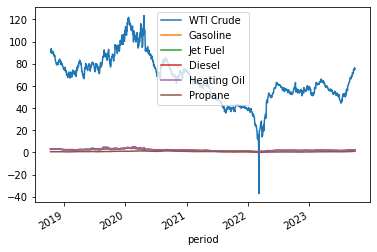

In [243]:
oil_products_df.plot()


In [88]:
#Getting Oil Price for Saudi Arabia from Fred
fred = Fred(api_key='57bd4282521725d9bf0fee73890bbdd7')
saudi_prices = fred.get_series('SAUPZPIOILBEGUSD')
wti_prices = fred.get_series('WTISPLC')


saudi_df = pd.DataFrame(saudi_prices)
saudi_df.columns = ['Price']
saudi_df.head()

,Price
2008-01-01,37.611394
2009-01-01,73.642577
2010-01-01,67.572343
2011-01-01,77.053879
2012-01-01,77.945163


In [89]:
urals_df = pd.read_csv('data/urals_prices.csv', sep=';')
urals_df.head()

,09.11.2023,68.46
0,08.11.2023,68.41
1,07.11.2023,70.46
2,06.11.2023,74.04
3,03.11.2023,73.80
4,02.11.2023,74.46


<AxesSubplot:>

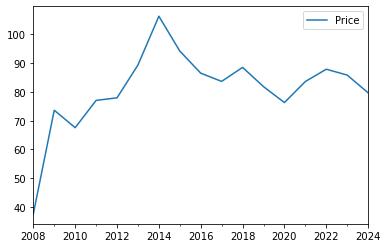

In [90]:
#Plotting
saudi_df.plot()

<AxesSubplot:>

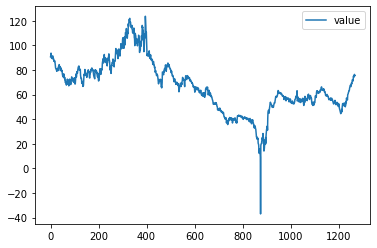

In [91]:
wti_df.plot()

<AxesSubplot:>

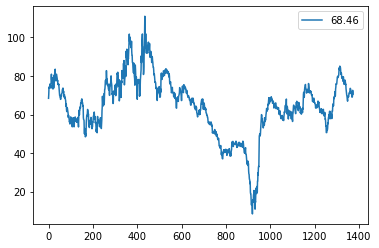

In [93]:
urals_df.plot()